## Connect the gdrive and change working directory to `/content/gdrive/MyDrive/Colab_Notebooks/lrcn/`

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab_Notebooks/lrcn/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab_Notebooks/lrcn


## Load the required packages

In [ ]:
from keras import Sequential, regularizers, Model, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization, concatenate, add
from tensorflow.keras.optimizers import Adam
from keras.layers import SpatialDropout1D, LSTM, Dense, Dropout, MaxPooling1D, Conv1D, GRU, TimeDistributed, Flatten
import numpy as np
import pandas as pd
import random
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
import keras.backend as K
# from models import Bayesian_optimizer
from evaluations import plot, ROC_PR
from tensorflow.keras.layers import RepeatVector, Concatenate, Add

## Helper functions to load and prepare the data

In [ ]:
def masked_loss_function(y_true, y_pred):
    '''
    Custom loss function
    '''
    mask = K.cast(K.not_equal(y_true, -1), K.floatx())
    return K.binary_crossentropy(y_true * mask, y_pred * mask)


def masked_accuracy(y_true, y_pred):
    '''
    Custom accuracy function.
    '''
    dtype = K.floatx()
    total = K.sum(K.cast(K.not_equal(y_true, -1), dtype))
    correct = K.sum(K.cast(K.equal(y_true, K.round(y_pred)), dtype))
    return correct / total


def prepare_data(features, label, lrcn):
    '''
    This function prepare the data for LRCN and WnD depending on the argment passed.
    '''
    # TODO
    FrameSize = 200

    y = []
    # temp_label = label
    for i in range(0, len(label)):
        # print(i)
        label[i] = label[i].values.tolist()

    for j in range(0, len(label[0])):
        tmp = []
        for i in range(0, len(label)):
            if label[i][j][0] != 0.0 and label[i][j][0] != 1.0:
                tmp.extend([-1])
            else:
                tmp.extend(label[i][j])
        y.append(tmp)


    if lrcn==True:
        X = features.values.tolist()
        for i in range(0, len(X)):
            if len(X[i]) < ((len(X[i]) // FrameSize + 1) * FrameSize):
                for j in range(0, (((len(X[i]) // FrameSize + 1) * FrameSize) - len(X[i]))):
                    X[i].append(0)
            X[i] = np.reshape(X[i], (FrameSize, len(X[i]) // FrameSize))
        X = np.array(X)
        y = np.array(y)
        return X, y, FrameSize

    else:
        features = np.array(features)
        y = np.array(y)
        return features, y, FrameSize


# def prepare_data_wnd(features, label):
#     FrameSize = 200

#     y = []
#     for i in range(0, len(label)):
#         label[i] = label[i].values.tolist()

#     for j in range(0, len(label[0])):
#         tmp = []
#         for i in range(0, len(label)):
#             if label[i][j][0] != 0.0 and label[i][j][0] != 1.0:
#                 tmp.extend([-1])
#             else:
#                 tmp.extend(label[i][j])
#         y.append(tmp)

#     y = np.array(y)
#     features = np.array(features)
#     return features, y, FrameSize



def load_data_gene_dataset(path):
    '''
    This function load the gene burden-based data.
    '''
    dt = pd.read_csv(path + 'gene_data.csv', header=None)
    dt.set_index(dt.columns[0], inplace=True, drop=True)
    return dt



def load_data(lst, path):
    '''
    This function loads the SNP data files 1-38.
    '''

    lst = sorted(np.unique(lst))
    dtypes = dict(zip(list(range(0, 20000)), [np.float32] * 20000))

    if lst[0] == 1:
        dt = pd.read_csv(path + 'SNP_data/' + 'file-' + str(lst[0]) + '.csv', header=None)
        dt.set_index(dt.columns[0], inplace=True, drop=True)
        dt = dt.astype(np.int8)
    else:
        dt = pd.read_csv(path + 'SNP_data/' + 'file-' + str(lst[0]) + '.csv', header=None, dtype=dtypes)
        isolates = pd.read_csv(path + 'iso_list.csv', header=None)[0].values.tolist()
        dt.index = isolates

    for i in lst[1:]:
        tmp = pd.read_csv(path + 'SNP_data/' + 'file-' + str(i) + '.csv', header=None, dtype=dtypes)
        tmp.index = dt.index
        dt = pd.concat([dt, tmp], axis='columns', ignore_index=True)
        print("read {}th file".format(i))

    dt.columns = list(range(0, len(dt.columns)))

    print(dt.shape)
    dt = dt.loc[:, dt.sum() >= 0]
    print("After dropping")
    print(dt.shape)

    return (dt)


def load_label(path):
    '''
    This function load the labels for SNP data.
    '''
    dt = pd.read_csv(path + 'AllLabels' + '.csv')
    dt.set_index(dt.columns[0], inplace=True, drop=True)
    return dt


def process(num_of_files, nrow=0, gene=False, limited=False, gene_dataset=False, shuffle_index=False, random_data=False,
            shuffle_operon=False, shuffle_operon_locally=False, shuffle_operon_group=False, index_file=0):
    
    '''
    Just a helper function.
    '''
    
    if gene:
        df_train = load_data.load_data_gene(list(range(0, num_of_files)), 'Data/')

    # if above condition is not satisfied 
    elif gene_dataset:
        df_train = load_data_gene_dataset('Data/')
    elif shuffle_index:
        df_train = load_data_shuffle_dataset('Data/', index_file)
    elif random_data:
        df_train = load_data_random_dataset('Data/')
    elif shuffle_operon:
        df_train = load_data_operon_dataset('Data/')
    elif shuffle_operon_locally:
        df_train = load_data_operon_locally_dataset('Data/')
    elif shuffle_operon_group:
        df_train = load_data_operon_group_dataset('Data/')
    else:
        df_train = load_data(list(range(1, num_of_files)), 'Data/')

    # df_train = df_train[df_train.columns[df_train.sum() > 5]]

    df_label = load_label('Data/') # read alllabels.csv file 

    if limited:
        df_label = df_label.drop(['ciprofloxacin'], axis=1)
        df_label = df_label.drop(['capreomycin'], axis=1)
        df_label = df_label.drop(['amikacin'], axis=1)
        df_label = df_label.drop(['ethionamide'], axis=1)
        df_label = df_label.drop(['moxifloxacin'], axis=1)


    print('label set: {0}'.format(df_label.shape))

    df_train = df_train.merge(df_label, left_index=True, right_index=True)

    print('train set: {0}'.format(df_train.shape))
    labels = []

    labels_list = []

    dfStreptomycin = df_train[['streptomycin']]
    labels.append(dfStreptomycin)
    labels_list.append(df_train['streptomycin'])

    dfRifampicin = df_train[['rifampicin']]
    labels.append(dfRifampicin)
    labels_list.append(df_train['rifampicin'])

    dfPyrazinamide = df_train[['pyrazinamide']]
    labels.append(dfPyrazinamide)
    labels_list.append(df_train['pyrazinamide'])


    dfOfloxacin = df_train[['ofloxacin']]
    labels.append(dfOfloxacin)
    labels_list.append(df_train['ofloxacin'])


    if not limited:
        dfMoxifloxacin = df_train[['moxifloxacin']]
        labels.append(dfMoxifloxacin)
        labels_list.append(df_train['moxifloxacin'])

    dfKanamycin = df_train[['kanamycin']]
    labels.append(dfKanamycin)
    labels_list.append(df_train['kanamycin'])


    dfIsoniazid = df_train[['isoniazid']]
    labels.append(dfIsoniazid)
    labels_list.append(df_train['isoniazid'])


    if not limited:
        dfEthionamide = df_train[['ethionamide']]
        labels.append(dfEthionamide)
        labels_list.append(df_train['ethionamide'])

    dfEthambutol = df_train[['ethambutol']]
    labels.append(dfEthambutol)
    labels_list.append(df_train['ethambutol'])


    if not limited:
        dfCiprofloxacin = df_train[['ciprofloxacin']]
        labels.append(dfCiprofloxacin)
        labels_list.append(df_train['ciprofloxacin'])

        dfCapreomycin = df_train[['capreomycin']]
        labels.append(dfCapreomycin)
        labels_list.append(df_train['capreomycin'])

        dfAmikacin = df_train[['amikacin']]
        labels.append(dfAmikacin)
        labels_list.append(df_train['amikacin'])

    df_train = df_train.drop(['streptomycin'], axis=1)
    df_train = df_train.drop(['rifampicin'], axis=1)
    df_train = df_train.drop(['pyrazinamide'], axis=1)
    df_train = df_train.drop(['ofloxacin'], axis=1)
    if not limited:
        df_train = df_train.drop(['moxifloxacin'], axis=1)
    df_train = df_train.drop(['kanamycin'], axis=1)
    df_train = df_train.drop(['isoniazid'], axis=1)
    if not limited:
        df_train = df_train.drop(['ethionamide'], axis=1)
    df_train = df_train.drop(['ethambutol'], axis=1)
    if not limited:
        df_train = df_train.drop(['ciprofloxacin'], axis=1)
        df_train = df_train.drop(['capreomycin'], axis=1)
        df_train = df_train.drop(['amikacin'], axis=1)
    # print(dfStreptomycin.head(10))
    if gene:
        df_train = one_hot_gene(df_train)


    # common_elements(labels_list)

    return df_train, labels


def one_hot_gene(df_train):
    # df_train = df_train.iloc[0:50]
    tmp = df_train.values.tolist()
    for i in range(0, len(tmp)):
        if i % 100 == 0:
            print(i)
        for j in range(0, len(tmp[0])):
            one = []
            for k in range(0, len(tmp[i][j])):
                if tmp[i][j][k] == 'A':
                    one.append(True)
                    one.append(False)
                    one.append(False)
                    one.append(False)
                elif tmp[i][j][k] == 'C':
                    one.append(False)
                    one.append(True)
                    one.append(False)
                    one.append(False)
                elif tmp[i][j][k] == 'T':
                    one.append(False)
                    one.append(False)
                    one.append(True)
                    one.append(False)
                elif tmp[i][j][k] == 'G':
                    one.append(False)
                    one.append(False)
                    one.append(False)
                    one.append(True)
                else:
                    print("Error!")
            tmp[i][j] = one
    # print(pd.DataFrame(tmp))
    return pd.DataFrame(tmp)

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.8 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(X1, X1_train, X1_test, y1_train, y1_test, FrameSize2, X2, X2_train, X2_test, y2_train, y2_test, hp):

    '''
    This is the function for the model Wide and Deep + LRCN. 
    '''

    #channel 1
    input_wnd = Input(shape=(X1_train.shape[1],))

    wnddense_layer_1 = Dense(hp.Int('dense_layer_1', 8, 256, step=8, default=256),activation="relu")(input_wnd)
    wndbatchnorm_layer_1 = BatchNormalization()(wnddense_layer_1)
    wnddropout_1 = Dropout(hp.Float('dropout_1', 0.10, 0.70, step=0.10, default=0.20))(wndbatchnorm_layer_1)
    wnddense_layer_2 = Dense(hp.Int('dense_layer_2', 8, 256, step=8, default=256), activation="relu")(wnddropout_1)
    wndbatchnorm_layer_2 = BatchNormalization()(wnddense_layer_2)
    wnddropout_2 = Dropout(hp.Float('dropout_2', 0.10, 0.70, step=0.10, default=0.20))(wndbatchnorm_layer_2)

    #check the dimensions and shape of WDNN input and output layer
    print("Output shape of input_wnd layer: {}".format(input_wnd.shape))
    print("Output shape of wnddropout_2 layer: {}".format(wnddropout_2.shape))

    #concate 
    wndconcat_layer_1 = concatenate([input_wnd, wnddropout_2], axis=1)
    
    #I can also try add instead of concatenation, some say it works better 
    # wndconcat_layer_1 = add([input_wnd, wnddropout_2])

    # #final layer
    # wndpreds = Dense(12, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg))(wndconcat_layer_1)
    # model = Model(inputs=input_wnd, outputs=wndpreds)
    # opt = Adam(lr=0.01)
    # model.compile(optimizer=opt, loss=masked_loss_function, metrics=[masked_accuracy])



    #channel 2
    input_lrcn = Input(shape=(FrameSize2, X2[0].shape[1]))

    lrcnconv1d_layer_1 = Conv1D(filters=hp.Int('filters_1', 8, 32, step=4, default=8), kernel_size=hp.Int('kernel_size_1', 3, 9, step=1, default=3), activation='relu', padding='same')(input_lrcn)
    lrcnmaxpool_layer_1 = MaxPooling1D(pool_size=hp.Int('pool_size_1', 1, 3, step=1, default=3), padding='same')(lrcnconv1d_layer_1)
    lrcnlstm_layer_1 = LSTM(hp.Int('LSTM_layer_1', 8, 256, step=16, default=256), return_sequences=False, recurrent_dropout=0.3)(lrcnmaxpool_layer_1)
    lrcndropout_layer_1 = Dropout(hp.Float('dropout_3', 0.10, 0.70, step=0.10, default=0.10))(lrcnlstm_layer_1)
    lrcndense_layer_1 = Dense(hp.Int('dense_layer_3', 8, 128, step=4, default=64))(lrcndropout_layer_1)
    lrcndropout_layer_2 = Dropout(hp.Float('dropout_4', 0.10, 0.70, step=0.10, default=0.10))(lrcndense_layer_1)



    # correct the shape

    print("Output shape of wnd: {}".format(wndconcat_layer_1.shape))
    # print("Output shape of wnd repeated: {}".format(wndconcat_layer_1_repeated.shape))
    print("Output shape of lrcn: {}".format(lrcndropout_layer_2.shape))

    #concate wnd and lrcn 
    concat_both = concatenate([wndconcat_layer_1, lrcndropout_layer_2], axis=1)

    #interpretation
    dense_layer_prefinal = Dense(hp.Int('dense_layer_4', 8, 128, step=4, default=64), activation='relu')(concat_both)

    #final layer
    preds = Dense(12, activation='sigmoid')(dense_layer_prefinal)


    model = Model(inputs=[input_wnd, input_lrcn], outputs=preds)


    opt = Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    model.compile(optimizer=opt, loss=masked_loss_function, metrics=[masked_accuracy])

    plot_model(model, to_file='Data/plot_/wnd_lrcn_hp_no_of_layers.png', show_shapes=True, show_layer_names=True)

    return model

In [ ]:
def create_plots(model, X1_test, X2_test, y2_test, name):
    """
    This function call the ROC and ROC_Score functions from ROC_PR.py file to
    generate plots for Accuracy, loss, ROC for each and all genes. 
    """

    score = ROC_PR.ROC(model, X1_test, X2_test, y2_test, name, True)
    return score, ROC_PR.ROC_Score(model, [X1_train, X2_train], y2_train, limited=False)

## Load WND data

In [ ]:
df_train, labels = process(3, gene_dataset=True)
X1, y1, FrameSize1 = prepare_data(df_train, labels, lrcn=False)
# X1 = to_categorical(X1, dtype=np.int8)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1, shuffle=True)

label set: (22376, 12)
train set: (7845, 3979)


## Load LRCN data

In [ ]:
df_train, labels = process(3, gene_dataset=True)
X2, y2, FrameSize2 = prepare_data(df_train, labels, lrcn=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=1, shuffle=True)

label set: (22376, 12)
train set: (7845, 3979)


In [ ]:
# params 
epochs = 50
batch_size = 128
earlyStopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', min_delta=0.1, verbose=1, patience=50)

In [ ]:
from functools import partial

lrs = partial(build_model, X1, X1_train, X1_test, y1_train, y1_test, FrameSize2, X2, X2_train, X2_test, y2_train, y2_test)

# lrs = build_model(kt.HyperParameters(), X1, X1_train, X1_test, y1_train, y1_test, FrameSize2, X2, X2_train, X2_test, y2_train, y2_test)

tuner = kt.BayesianOptimization(
    lrs,
    objective=kt.Objective("val_masked_accuracy", direction="max"),
    max_trials=500,
    seed=42
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
Output shape of input_wnd layer: (None, 3967)
Output shape of wnddropout_2 layer: (None, 256)
Output shape of wnd: (None, 4223)
Output shape of lrcn: (None, 64)
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
#tells us how many hyperparameters we are tuning
#in our case it's 3 =layers,neurons,learning rate
tuner.search_space_summary()

Search space summary
Default search space size: 13
dense_layer_1 (Int)
{'default': 256, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.1, 'max_value': 0.7, 'step': 0.1, 'sampling': None}
dense_layer_2 (Int)
{'default': 256, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.1, 'max_value': 0.7, 'step': 0.1, 'sampling': None}
filters_1 (Int)
{'default': 8, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 4, 'sampling': None}
kernel_size_1 (Int)
{'default': 3, 'conditions': [], 'min_value': 3, 'max_value': 9, 'step': 1, 'sampling': None}
pool_size_1 (Int)
{'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
LSTM_layer_1 (Int)
{'default': 256, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 16, 'sampling': None}
dropout_3 (Float)


In [ ]:
#fitting the tuner
tuner.search([X1_train, X2_train],
             [y1_train, y2_train],
             epochs=epochs,
             batch_size=batch_size,
             steps_per_epoch= len([X2_train][0])//batch_size,
             validation_data=([X1_test, X2_test], y2_test),
             callbacks=[earlyStopping, ModelCheckpoint('Data/lrcn_wnd_checkpoint/lrcn_wnd_optimizer.h5', monitor='val_masked_accuracy', mode='max', save_best_only=True)]
             )

In [ ]:
best_model = tuner.get_best_models(1)[0]

Output shape of input_wnd layer: (None, 3967)
Output shape of wnddropout_2 layer: (None, 104)
Output shape of wnd: (None, 4071)
Output shape of lrcn: (None, 8)


In [ ]:
# best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_masked_accuracy', direction='max')
Trial summary
Hyperparameters:
dense_layer_1: 256
dropout_1: 0.5
dense_layer_2: 104
dropout_2: 0.1
filters_1: 32
kernel_size_1: 6
pool_size_1: 2
LSTM_layer_1: 8
dropout_3: 0.30000000000000004
dense_layer_3: 8
dropout_4: 0.7000000000000001
dense_layer_4: 128
learning_rate: 0.00023495992815036312
Score: 0.8600281476974487
Trial summary
Hyperparameters:
dense_layer_1: 256
dropout_1: 0.5
dense_layer_2: 64
dropout_2: 0.1
filters_1: 24
kernel_size_1: 7
pool_size_1: 2
LSTM_layer_1: 8
dropout_3: 0.30000000000000004
dense_layer_3: 24
dropout_4: 0.7000000000000001
dense_layer_4: 128
learning_rate: 0.0002840957637286847
Score: 0.8588727712631226
Trial summary
Hyperparameters:
dense_layer_1: 256
dropout_1: 0.4
dense_layer_2: 64
dropout_2: 0.1
filters_1: 32
kernel_size_1: 7
pool_size_1: 2
LSTM_layer_1: 8
dropout_3: 0.4
dense_layer_3: 44
dropout_4: 0.7000000000000001
dense_laye

In [ ]:
# extract the best model and generate the model plot, model history.
best_model.build()
best_model.summary()

TypeError: ignored

In [ ]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)

# Build the model with the best hp.
model = lrs(best_hps[0])

# Fit with the entire dataset.
history = model.fit(
                [X1_train, X2_train],
                [y1_train, y2_train],
                epochs=epochs,
                batch_size=batch_size,
                verbose=2,
                steps_per_epoch=len([X2_train][0])//batch_size,
                validation_data=([X1_test, X2_test], y2_test),
                callbacks=[earlyStopping, ModelCheckpoint('Data/lrcn_wnd_checkpoint/lrcn_wnd.h5', monitor='val_masked_accuracy', mode='max', save_best_only=True)]
)

Output shape of input_wnd layer: (None, 3967)
Output shape of wnddropout_2 layer: (None, 104)
Output shape of wnd: (None, 4071)
Output shape of lrcn: (None, 8)
Epoch 1/50
49/49 - 31s - loss: 0.2628 - masked_accuracy: 0.7098 - val_loss: 0.2407 - val_masked_accuracy: 0.7508 - 31s/epoch - 642ms/step
Epoch 2/50
49/49 - 19s - loss: 0.2177 - masked_accuracy: 0.7680 - val_loss: 0.2227 - val_masked_accuracy: 0.7772 - 19s/epoch - 378ms/step
Epoch 3/50
49/49 - 19s - loss: 0.1962 - masked_accuracy: 0.8049 - val_loss: 0.2123 - val_masked_accuracy: 0.7930 - 19s/epoch - 390ms/step
Epoch 4/50
49/49 - 19s - loss: 0.1806 - masked_accuracy: 0.8248 - val_loss: 0.2016 - val_masked_accuracy: 0.8083 - 19s/epoch - 380ms/step
Epoch 5/50
49/49 - 19s - loss: 0.1655 - masked_accuracy: 0.8369 - val_loss: 0.1968 - val_masked_accuracy: 0.8150 - 19s/epoch - 396ms/step
Epoch 6/50
49/49 - 18s - loss: 0.1536 - masked_accuracy: 0.8554 - val_loss: 0.1939 - val_masked_accuracy: 0.8136 - 18s/epoch - 372ms/step
Epoch 7/50
4

In [ ]:
best_hps[0]

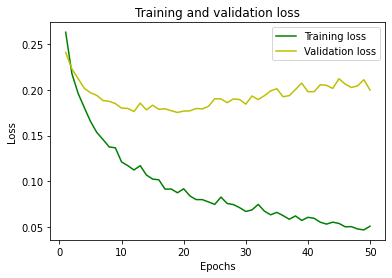

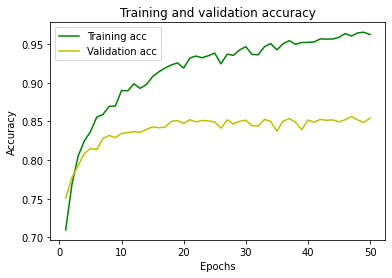

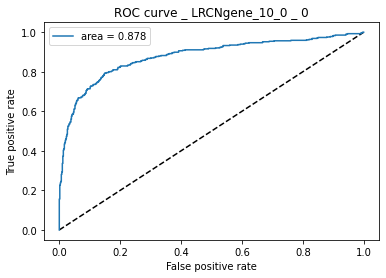

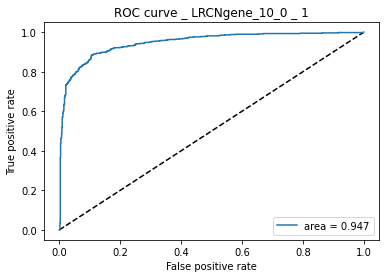

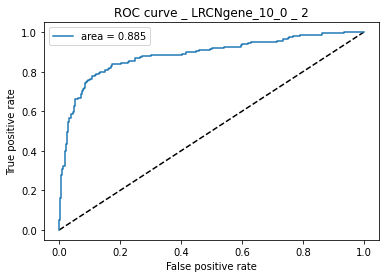

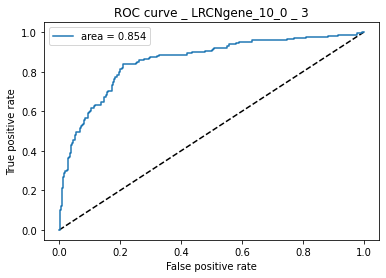

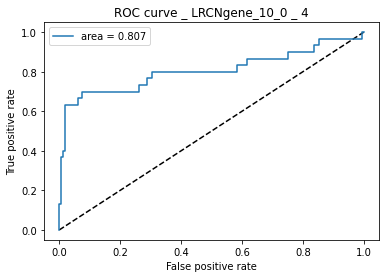

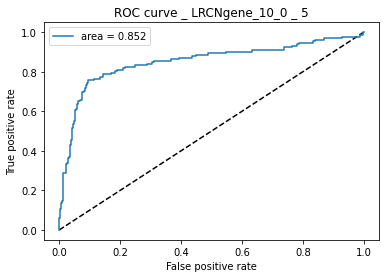

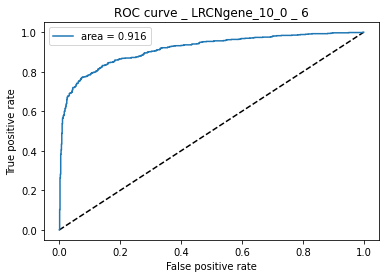

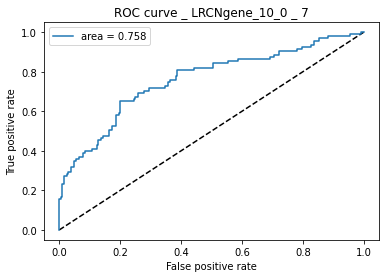

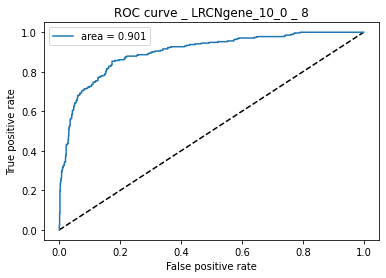

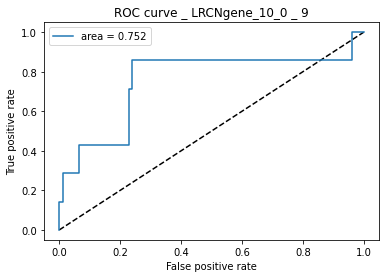

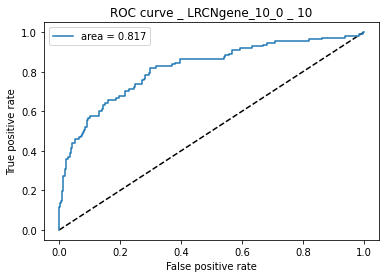

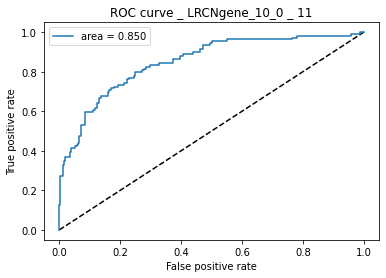

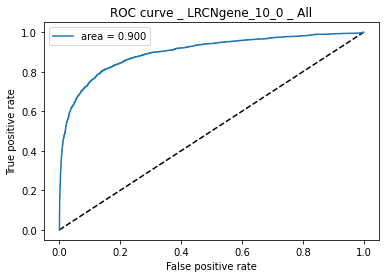

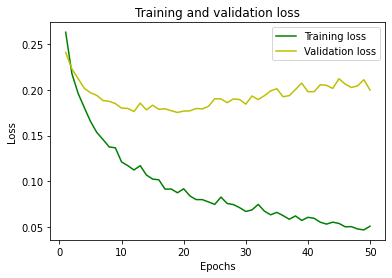

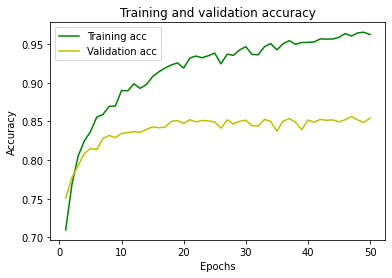

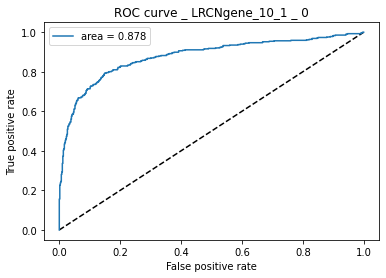

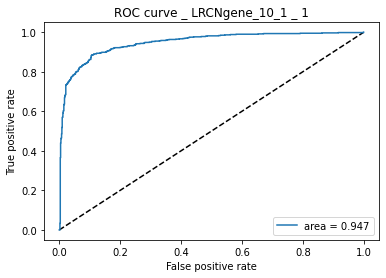

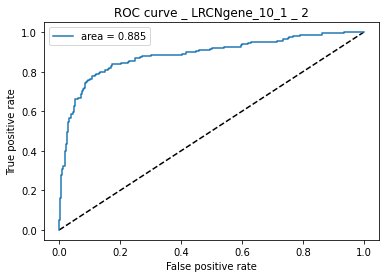

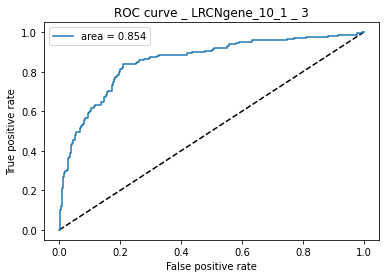

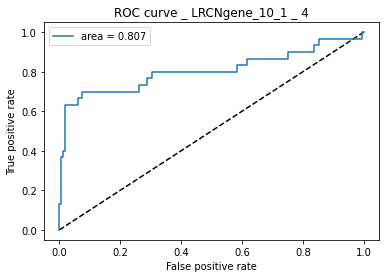

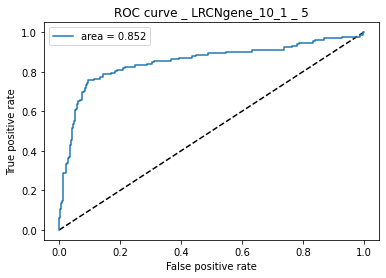

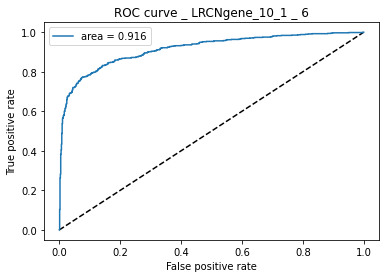

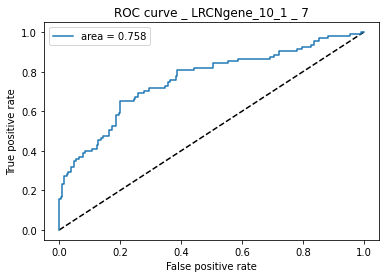

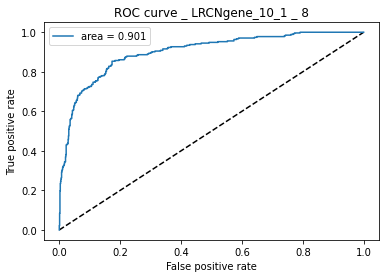

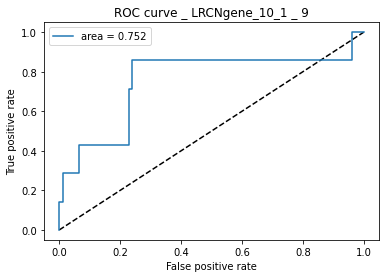

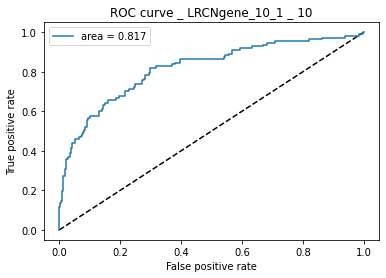

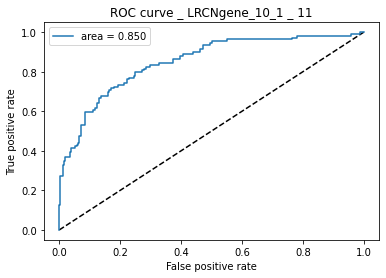

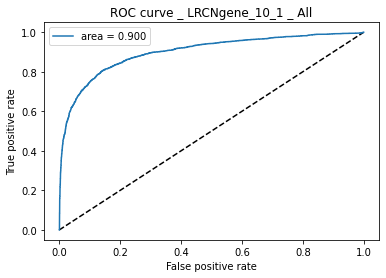

<Figure size 432x288 with 0 Axes>

In [ ]:
# after getting the best model, generate the plots.
for i in range(0,2):
    plot.plot(history, ("LRCN" + "gene_10_" + str(i)))
    create_plots(model, X1_test, X2_test, y2_test, name = ("LRCN" + "gene_10_" + str(i)))

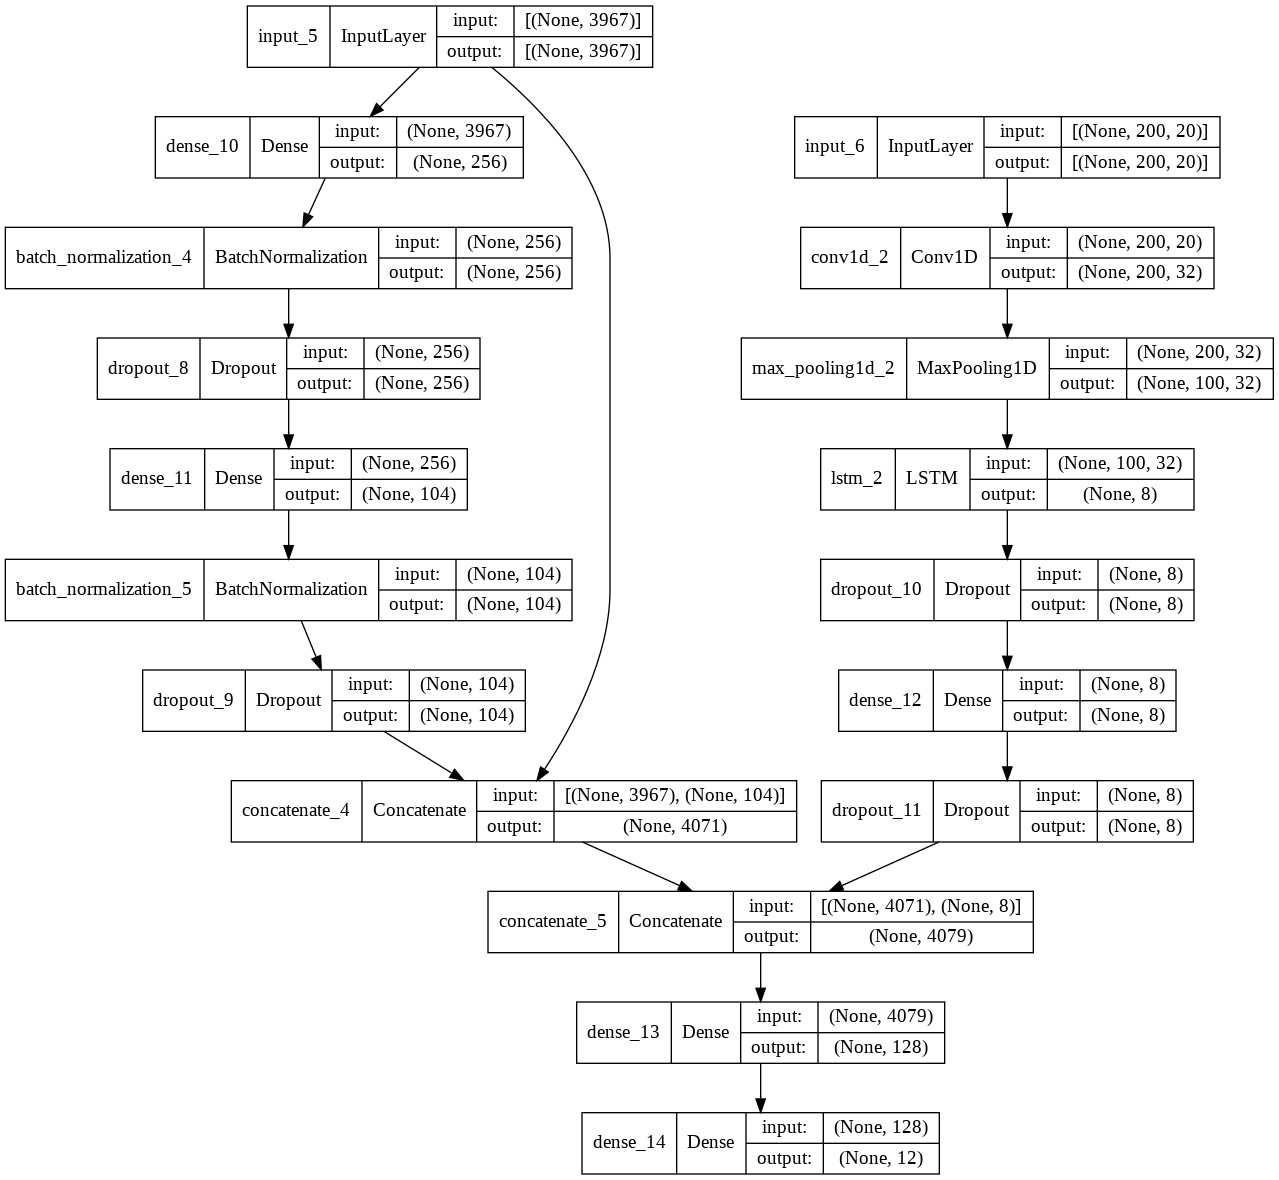

In [ ]:
plot_model(model, to_file='Data/plot_/wnd_lrcn_hp_no_of_layers.png', show_shapes=True, show_layer_names=True)

label set: (22376, 12)
train set: (7845, 3979)
Output shape of input_wnd layer: (None, 3967)
Output shape of wnddropout_2 layer: (None, 256)
Output shape of wnd: (None, 4223)
Output shape of lrcn: (None, 64)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
56/56 - 23s - loss: 0.5243 - masked_accuracy: 0.6466 - val_loss: 0.3152 - val_masked_accuracy: 0.6902 - 23s/epoch - 405ms/step
Epoch 2/50
56/56 - 10s - loss: 0.2683 - masked_accuracy: 0.7314 - val_loss: 0.2711 - val_masked_accuracy: 0.7374 - 10s/epoch - 180ms/step
Epoch 3/50
56/56 - 10s - loss: 0.2467 - masked_accuracy: 0.7668 - val_loss: 0.2546 - val_masked_accuracy: 0.7621 - 10s/epoch - 182ms/step
Epoch 4/50
56/56 - 10s - loss: 0.2247 - masked_accuracy: 0.7953 - val_loss: 0.2404 - val_masked_accuracy: 0.8017 - 10s/epoch - 180ms/step
Epoch 5/50
56/56 - 10s - loss: 0.2007 - masked_accuracy: 0.8184 - val_loss: 0.2313 - val_masked_accuracy: 0.8101 - 10s/epoch - 181ms/step
Epoch 6/50
56/56 - 10s - loss: 0.1906 - masked_accuracy: 0.8246 - val_loss: 0.2219 - val_masked_accuracy: 0.8104 - 10s/epoch - 180ms/step
Epoch 7/50
56/56 - 10s - loss: 0.1838 - masked_accuracy: 0.8345 - val_loss: 0.2334 - val_masked_accuracy: 0.8086 - 10s/epoch - 181ms/step
Epoch 8/50
56/56 - 10s - loss: 0.1

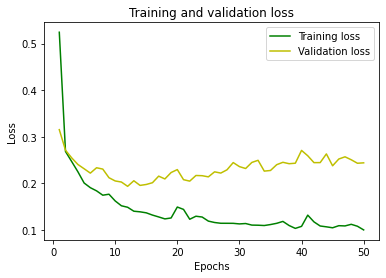

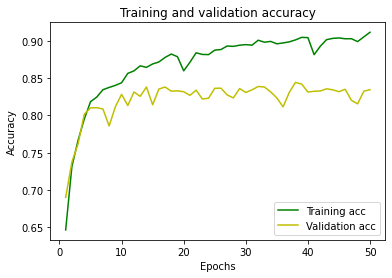

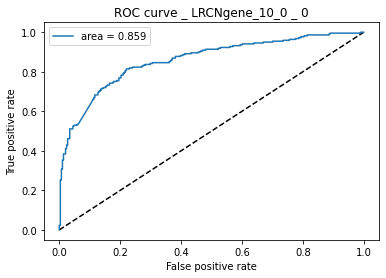

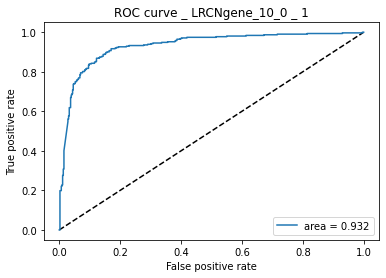

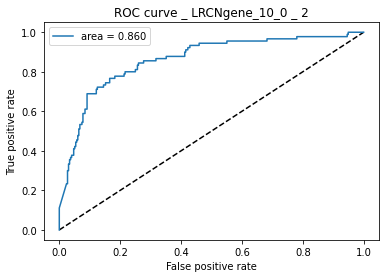

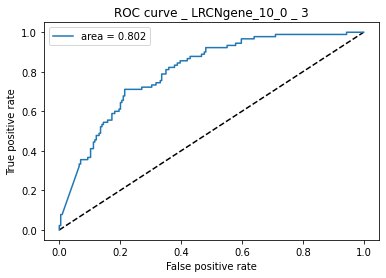

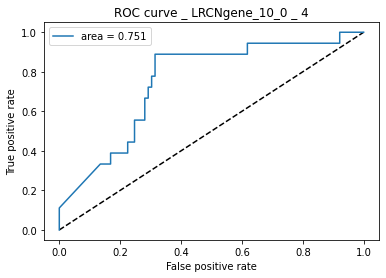

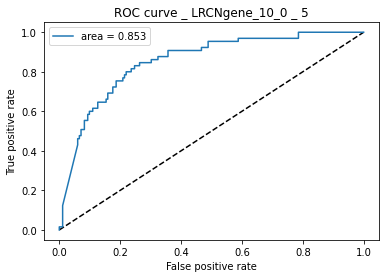

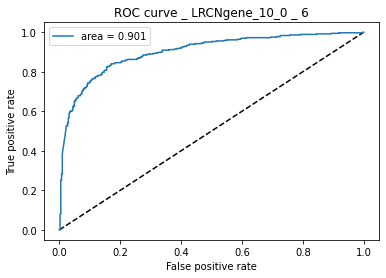

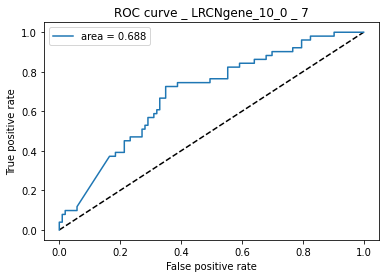

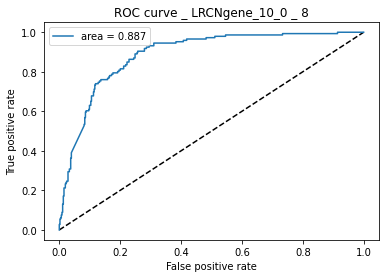

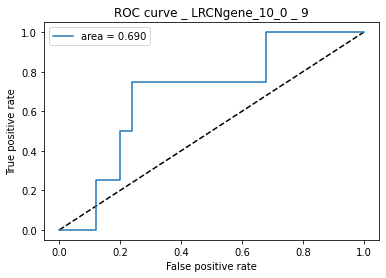

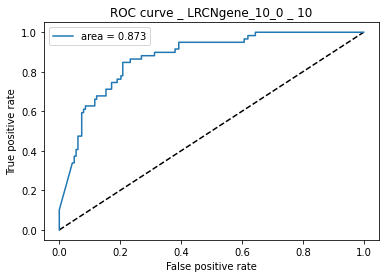

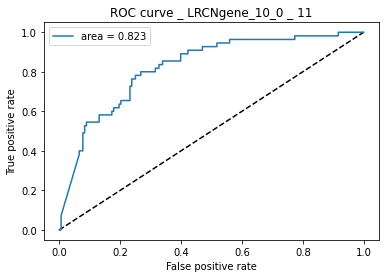

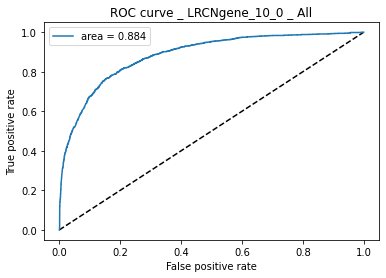

Output shape of input_wnd layer: (None, 3967)
Output shape of wnddropout_2 layer: (None, 256)
Output shape of wnd: (None, 4223)
Output shape of lrcn: (None, 64)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
56/56 - 14s - loss: 0.4260 - masked_accuracy: 0.7148 - val_loss: 0.2781 - val_masked_accuracy: 0.7580 - 14s/epoch - 244ms/step
Epoch 2/50
56/56 - 10s - loss: 0.2487 - masked_accuracy: 0.7586 - val_loss: 0.2536 - val_masked_accuracy: 0.7584 - 10s/epoch - 182ms/step
Epoch 3/50
56/56 - 10s - loss: 0.2259 - masked_accuracy: 0.7745 - val_loss: 0.2386 - val_masked_accuracy: 0.7692 - 10s/epoch - 182ms/step
Epoch 4/50
56/56 - 10s - loss: 0.2221 - masked_accuracy: 0.7961 - val_loss: 0.2922 - val_masked_accuracy: 0.7706 - 10s/epoch - 184ms/step
Epoch 5/50
56/56 - 11s - loss: 0.2034 - masked_accuracy: 0.8113 - val_loss: 0.2602 - val_masked_accuracy: 0.7870 - 11s/epoch - 188ms/step
Epoch 6/50
56/56 - 11s - loss: 0.1998 - masked_accuracy: 0.8155 - val_loss: 0.2549 - val_masked_accuracy: 0.7902 - 11s/epoch - 198ms/step
Epoch 7/50
56/56 - 10s - loss: 0.1897 - masked_accuracy: 0.8252 - val_loss: 0.2168 - val_masked_accuracy: 0.8139 - 10s/epoch - 184ms/step
Epoch 8/50
56/56 - 10s - loss: 0.1

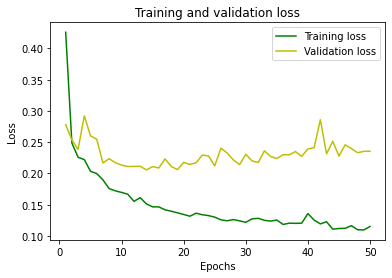

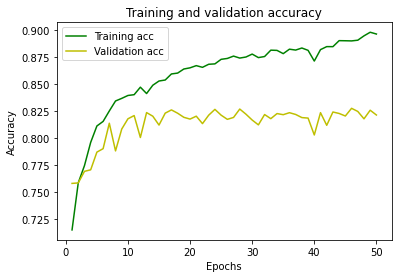

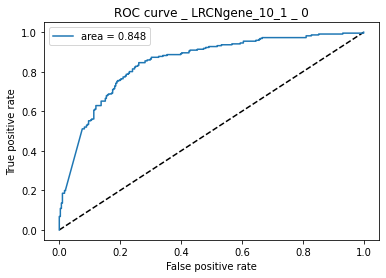

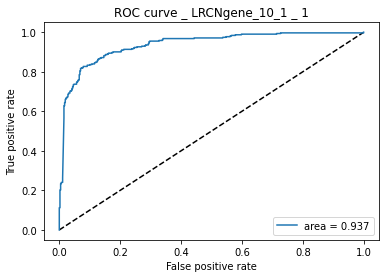

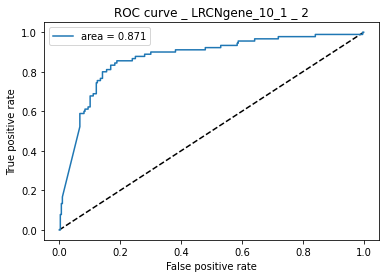

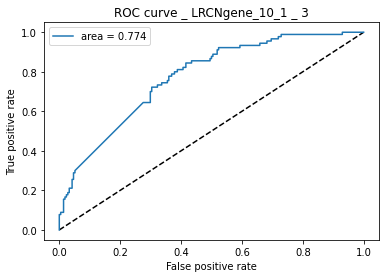

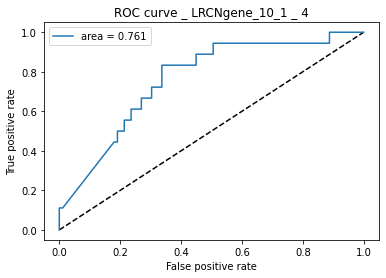

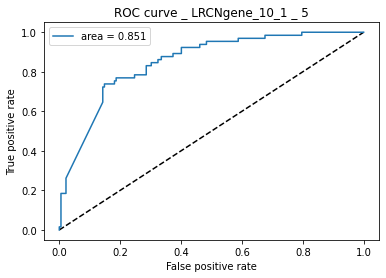

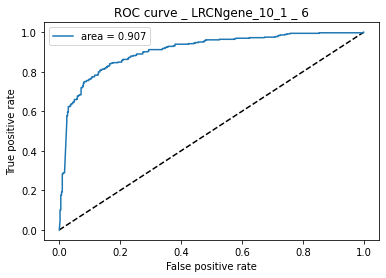

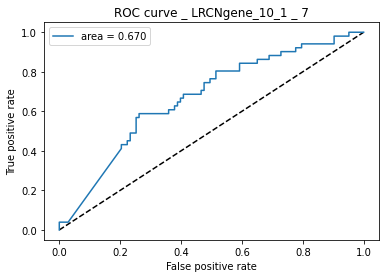

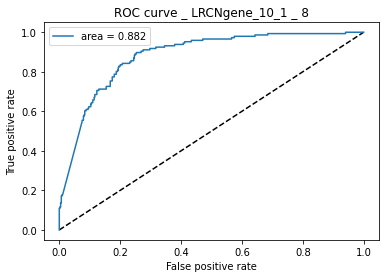

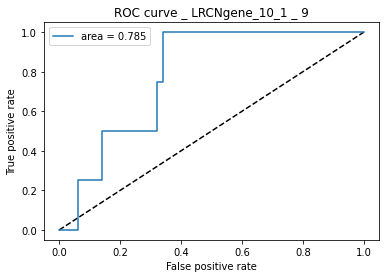

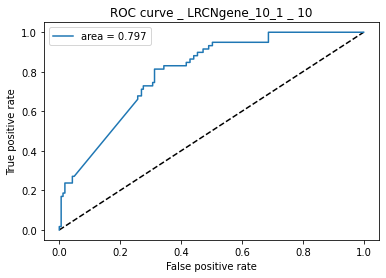

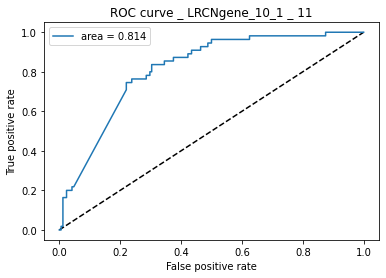

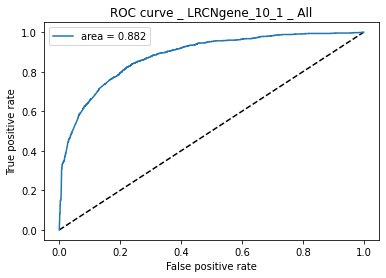

<Figure size 432x288 with 0 Axes>